<a href="https://colab.research.google.com/github/nasdag/challenges/blob/master/searches_booking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! mkdir -p data
! cp drive/My\ Drive/SENONI/challenges/amadeus/data/*csv.bz2 data

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages io.delta:delta-core_2.11:0.5.0 pyspark-shell'

def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !java -version
install_java()

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [3]:
! pip install -q pyspark
! pip install -q databricks
! pip install -q koalas

     |████████████████████████████████| 217.8MB 57kB/s 
     |████████████████████████████████| 204kB 56.6MB/s 
     |████████████████████████████████| 583kB 1.3MB/s 


In [0]:
! spark-submit --packages io.delta:delta-core_2.11:0.5.0 doesnotexist.py >> /dev/null 2>> /dev/null

In [0]:
import databricks.koalas as ks

from pyspark.sql.types import *
from pyspark.sql.functions import col, concat, to_date, unix_timestamp, lit, rtrim

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

In [7]:
ks.sql("show databases")

,databaseName
0,default


In [8]:
ks.sql("show tables")

,database,tableName,isTemporary


**Question 1: reading files**

Check the number of lines in each of the two files (bookings and searches)

In [0]:
df = spark.read.format("csv").option("header", "true").option("delimiter", "^").load("data/bookings.csv.bz2")
for colname in df.columns:
    newname = colname.strip()
    df = df.withColumnRenamed(colname, newname)
    df = df.withColumn(newname, rtrim(col(newname)))
    if newname in ["act_date", "cre_date", "brd_time", "off_time"]:
        df = df.withColumn(newname, col(newname).cast("timestamp"))
    if newname in ["duration", "distance", "intl", "pax", "year", "month"]:
        df = df.withColumn(newname, col(newname).cast("int"))
df.dropDuplicates().write.mode('overwrite').option("mergeSchema", "true").format("delta").save('data/bookings')

In [0]:
df = spark.read.format("csv").option("header", "true").option("delimiter", "^").load("data/searches.csv.bz2")
df = df.withColumn("event_ts", concat(to_date((unix_timestamp(col("Date"), 'yyyy-MM-dd')).cast("timestamp")), lit(' '), col("Time")).cast("timestamp"))
df = df.drop("Date").drop("Time")
for colname in df.columns:
    if colname in ["Seg1Date", "Seg2Date", "Seg3Date", "Seg4Date", "Seg5Date", "Seg6Date"]:
        df = df.withColumn(colname, col(colname).cast("timestamp"))
    if colname in ["NbSegments"]:
        df = df.withColumn(colname, col(colname).cast("int"))
    if colname in ["RoundTrip", "IsPublishedForNeg", "IsFromInternet", "IsFromVista"]:
        df = df.withColumn(colname, col(colname).cast("boolean"))

df.dropDuplicates().write.mode('overwrite').option("mergeSchema", "true").format("delta").save('data/searches')

In [0]:
bookings = ks.read_delta("data/bookings")
searches = ks.read_delta("data/searches")

In [12]:
bookings.shape

(1000002, 38)

In [13]:
searches.shape

(359004, 44)

In [14]:
ks.sql("select count(*) from {bookings}")

,count(1)
0,1000002


In [15]:
ks.sql("select count(*) from {searches}")

,count(1)
0,359004


In [16]:
#bookings.head()
ks.sql("select * from {bookings} limit 5")

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-05-22,1A,DK,9e527a3e3cab21307ebad6f59e7c643b,4caf98fe1b209342883e5bbf5a81cd1f,377b6d065b3934b2867ca17c40ece609,2013-05-13,29034,0,AAL,AAL,DK,BKK,BKK,TH,AAL,AAL,DK,BKK,BKK,TH,AAL,AAL,DK,AALBKK,AALBKK,DKTH,1,BKKDOHCPHAAL,BC,H,Y,2013-09-29 02:10:00,2013-09-29 17:24:48,2,2013,5,CPHSG38SR
1,2013-01-08,1A,AE,36eb7d5356e5f709f729fc4700d2cf0f,9cf89903c4ac265ae021f077f28c1329,a32c69b7b08f5ee9389875291eae5235,2013-01-08,86694,0,AAN,AAN,AE,MNL,MNL,PH,AAN,AAN,AE,MNL,MNL,PH,AAN,AAN,AE,AANMNL,AANMNL,AEPH,1,MNLAUHAAN,OJ,V,Y,2013-03-24 17:50:00,2013-03-25 02:54:58,1,2013,1,NULL
2,2013-01-15,1A,DK,149ac67ae0f5177967e59348cab204c3,6cdbbc90898a28874556edce73e8df84,d3f6730479cbacb4e0e735cdf78245f5,2013-01-03,573,0,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,AARCPH,AARCPH,DKDK,0,CPHAAR,DU,M,Y,2013-01-15 17:10:00,2013-01-15 18:08:25,-1,2013,1,NULL
3,2013-10-25,1A,DK,8b20767fa692d3d0d5a51d18aeb31500,667adc6e65af8da3c7f61372778f3d0b,c17339d32e38d96eeb21aa79d2b1a05e,2013-10-25,1238,900,LHR,LON,GB,CPH,CPH,DK,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,AARCPH,AARCPH,DKDK,0,CPHAAR,DU,K,Y,2013-11-22 14:45:00,2013-11-22 15:43:25,1,2013,10,NULL
4,2013-01-29,1A,ES,0c40a216e46110a75b91bf8467444ab2,49aab7a4919cf057612a4c686ce22577,41a6f4ed11adb93084d73bc58b805227,2013-01-29,4658,0,MAD,MAD,ES,AAR,AAR,DK,MAD,MAD,ES,MAD,MAD,ES,AAR,AAR,DK,AARMAD,AARMAD,DKES,1,MADCPHAAR,DU,U,Y,2013-02-11 13:15:00,2013-02-11 18:08:25,1,2013,1,NULL


In [17]:
#searches.head()
ks.sql("select * from {searches} limit 5")

,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,event_ts
0,AFP,7da60d9e60a322d3fff7e00cb62baa53,BR,CGB,NVT,True,2,CGB,NVT,2014-07-06,None,None,NVT,CGB,2014-07-07,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,False,d41d8cd98f00b204e9800998ecf8427e,0,2013-10-05 03:33:49
1,AFP,cd1f51e3621a3a67440b4613b87fe3fb,BR,STM,CGR,True,2,STM,CGR,2014-02-12,None,None,CGR,STM,2014-02-13,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,False,d41d8cd98f00b204e9800998ecf8427e,0,2013-12-24 02:51:45
2,AFP,99a5fa66a00828db9727aea7ebc6ae74,DE,GRZ,DUS,False,1,GRZ,DUS,2014-02-11,None,None,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,False,d41d8cd98f00b204e9800998ecf8427e,0,2013-12-23 13:07:27
3,AFP,cb028e2166a95168fee7d483a463ae54,DE,GWT,DKR,True,2,GWT,DKR,2013-06-18,None,None,DKR,GWT,2013-06-21,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,False,d41d8cd98f00b204e9800998ecf8427e,FRA,2013-04-20 11:03:49
4,ANP,99a5fa66a00828db9727aea7ebc6ae74,DE,BRI,HAM,False,1,BRI,HAM,2013-11-01,KL,None,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,False,d41d8cd98f00b204e9800998ecf8427e,BER,2013-01-26 06:08:37


In [20]:
ks.sql("create table bookings using delta location 'data/bookings'")
ks.sql("create table searches using delta location 'data/searches'")

""


In [21]:
ks.sql("show tables")

,database,tableName,isTemporary
0,default,bookings,False
1,default,searches,False


In [22]:
ks.sql("select count(*) from bookings")

,count(1)
0,1000002


In [23]:
ks.sql("select * from bookings limit 5")

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-05-22,1A,DK,9e527a3e3cab21307ebad6f59e7c643b,4caf98fe1b209342883e5bbf5a81cd1f,377b6d065b3934b2867ca17c40ece609,2013-05-13,29034,0,AAL,AAL,DK,BKK,BKK,TH,AAL,AAL,DK,BKK,BKK,TH,AAL,AAL,DK,AALBKK,AALBKK,DKTH,1,BKKDOHCPHAAL,BC,H,Y,2013-09-29 02:10:00,2013-09-29 17:24:48,2,2013,5,CPHSG38SR
1,2013-01-08,1A,AE,36eb7d5356e5f709f729fc4700d2cf0f,9cf89903c4ac265ae021f077f28c1329,a32c69b7b08f5ee9389875291eae5235,2013-01-08,86694,0,AAN,AAN,AE,MNL,MNL,PH,AAN,AAN,AE,MNL,MNL,PH,AAN,AAN,AE,AANMNL,AANMNL,AEPH,1,MNLAUHAAN,OJ,V,Y,2013-03-24 17:50:00,2013-03-25 02:54:58,1,2013,1,NULL
2,2013-01-15,1A,DK,149ac67ae0f5177967e59348cab204c3,6cdbbc90898a28874556edce73e8df84,d3f6730479cbacb4e0e735cdf78245f5,2013-01-03,573,0,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,AARCPH,AARCPH,DKDK,0,CPHAAR,DU,M,Y,2013-01-15 17:10:00,2013-01-15 18:08:25,-1,2013,1,NULL
3,2013-10-25,1A,DK,8b20767fa692d3d0d5a51d18aeb31500,667adc6e65af8da3c7f61372778f3d0b,c17339d32e38d96eeb21aa79d2b1a05e,2013-10-25,1238,900,LHR,LON,GB,CPH,CPH,DK,AAR,AAR,DK,CPH,CPH,DK,AAR,AAR,DK,AARCPH,AARCPH,DKDK,0,CPHAAR,DU,K,Y,2013-11-22 14:45:00,2013-11-22 15:43:25,1,2013,10,NULL
4,2013-01-29,1A,ES,0c40a216e46110a75b91bf8467444ab2,49aab7a4919cf057612a4c686ce22577,41a6f4ed11adb93084d73bc58b805227,2013-01-29,4658,0,MAD,MAD,ES,AAR,AAR,DK,MAD,MAD,ES,MAD,MAD,ES,AAR,AAR,DK,AARMAD,AARMAD,DKES,1,MADCPHAAR,DU,U,Y,2013-02-11 13:15:00,2013-02-11 18:08:25,1,2013,1,NULL


In [24]:
ks.sql("describe bookings")

,col_name,data_type,comment
0,act_date,timestamp,None
1,source,string,None
2,pos_ctry,string,None
3,pos_iata,string,None
4,pos_oid,string,None
5,rloc,string,None
6,cre_date,timestamp,None
7,duration,int,None
8,distance,int,None
9,dep_port,string,None


In [25]:
ks.sql("drop table if exists bookings")
ks.sql("drop table if exists searches")
ks.sql("show tables")

,database,tableName,isTemporary


**Question 2: top 10 arrival airports in the world in 2013 (using the bookings file)**

Arrival airport is the column arr_port. It is the IATA code for the airport

To get the total number of passengers for an airport, you can sum the column pax, grouping by arr_port. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).

Print the top 10 arrival airports in the standard output, including the number of passengers.

Required: Get the name of the city or airport corresponding to that airport (programmatically, we suggest to have a look at GeoBases or OpenTravelData in Github)

If you're using Python, can you solve this problem using pandas?

In [26]:
bookings.year.value_counts(dropna=False)

2013.0    1000001
NaN             1
Name: year, dtype: int64

In [27]:
#bookings.loc[bookings.year.isnull()]
ks.sql("select * from {bookings} where year is null")

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-25,1V JP,None,a37584d1485cb35991e4ff1a2ba92262,2013-03-25 00:00:00,8371,None,None,None,JP,SIN,SIN,SG,HND TYO,JP,NRT,TYO,JP,SIN,SIN,SG,NRTSIN,SINTYO,JPSG,1,NRTSIN,"XR,Q",None,2013-04-14 11:05:00,2013-04-14 17:10:56,2,2013,None,None,None,None,None,None


In [28]:
res = bookings.groupby('arr_port').pax.sum().sort_values(ascending=False).head(10)
res

arr_port
LHR    8881
MCO    7093
LAX    7053
LAS    6963
JFK    6627
CDG    6449
BKK    5946
MIA    5815
SFO    5800
DXB    5559
Name: pax, dtype: int64

In [29]:
! pip install -q datapackage

     |████████████████████████████████| 92kB 1.6MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 174kB 51.9MB/s 


In [30]:
import datapackage
package = datapackage.Package('https://datahub.io/core/airport-codes/datapackage.json')
! rm -f {package.resources[1].descriptor['path'].split('/')[-1]}
! wget -q {package.resources[1].descriptor['path']}
airport_codes = ks.read_csv('airport-codes_csv.csv')
airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


In [31]:
airport_codes[['name', 'iso_region', 'municipality', 'iata_code']
              ].merge(res, left_on=['iata_code'], right_index=True, how='right').reset_index(drop=True)

,name,iso_region,municipality,iata_code,pax
0,London Heathrow Airport,GB-ENG,London,LHR,8881
1,Orlando International Airport,US-FL,Orlando,MCO,7093
2,Los Angeles International Airport,US-CA,Los Angeles,LAX,7053
3,McCarran International Airport,US-NV,Las Vegas,LAS,6963
4,John F Kennedy International Airport,US-NY,New York,JFK,6627
5,Charles de Gaulle International Airport,FR-IDF,Paris,CDG,6449
6,Suvarnabhumi Airport,TH-10,Bangkok,BKK,5946
7,Miami International Airport,US-FL,Miami,MIA,5815
8,San Francisco International Airport,US-CA,San Francisco,SFO,5800
9,Dubai International Airport,AE-DU,Dubai,DXB,5559


In [0]:
ks.sql("drop table if exists airport_codes")
_ = ks.sql("create table airport_codes using csv options (path 'airport-codes_csv.csv', header 'true', inferSchema 'true')")

In [37]:
ks.sql("select * from airport_codes where iata_code=='JNB'")

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,FAJS,large_airport,OR Tambo International Airport,5558,AF,ZA,ZA-GT,Johannesburg,FAOR,JNB,None,"28.246, -26.1392"
1,FAOR,large_airport,OR Tambo International Airport,5558,AF,ZA,ZA-GT,Johannesburg,FAOR,JNB,None,"28.246, -26.1392"
2,JNB,large_airport,O R Tambo International,5558,AF,ZA,ZA-U-A,Johannesburg,FAOR,JNB,None,"28.246, -26.1392"


In [38]:
ks.sql("""select first(airport_codes1.name) as name, first(airport_codes1.iata_code) as iata_code, 
          first(airport_codes1.iso_region) as iso_region, first(airport_codes1.municipality) as municipality, 
          sum(bookings.pax) as pax from {bookings} as bookings
          left join (select * from (select *, row_number() over (partition by iata_code order by ident desc) as rn from airport_codes
          ) as o_airport_codes where o_airport_codes.rn=1) as airport_codes1 
          on bookings.arr_port=airport_codes1.iata_code
          group by bookings.arr_port order by pax desc limit 10""")

,name,iata_code,iso_region,municipality,pax
0,London Heathrow Airport,LHR,GB-ENG,London,8881
1,Orlando International Airport,MCO,US-FL,Orlando,7093
2,Los Angeles International Airport,LAX,US-CA,Los Angeles,7053
3,McCarran International Airport,LAS,US-NV,Las Vegas,6963
4,John F Kennedy International Airport,JFK,US-NY,New York,6627
5,Charles de Gaulle International Airport,CDG,FR-IDF,Paris,6449
6,Suvarnabhumi Airport,BKK,TH-10,Bangkok,5946
7,Miami International Airport,MIA,US-FL,Miami,5815
8,San Francisco International Airport,SFO,US-CA,San Francisco,5800
9,Dubai International Airport,DXB,AE-DU,Dubai,5559


**Question 3: visualization**

Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

For the arriving airport, you can use the Destination column in the searches file. Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure.

If you're using Python, can you solve this problem using pandas?

In [39]:
focus = airport_codes.loc[airport_codes.municipality.isin(['MÃ¡laga', 'Madrid', 'Barcelona']),
    ['municipality', 'iata_code']].dropna()
focus

,municipality,iata_code
31294,Barcelona,BCN
31307,Madrid,ECV
31357,Madrid,MAD
31359,MÃ¡laga,AGP
31415,Madrid,TOJ
47266,Barcelona,BLA


In [40]:
res = focus.merge(searches[['event_ts', 'Destination']], left_on='iata_code', right_on='Destination', 
                  how='left').drop('iata_code', axis=1).dropna(subset=['event_ts'])
res = res.assign(month=ks.to_datetime(res.event_ts.dt.date.astype(str).apply(lambda x: x[:-2]+'01')))
res.head()

,municipality,event_ts,Destination,month
0,Barcelona,2013-12-12 08:41:01,BCN,2013-12-01
1,Barcelona,2013-04-28 09:50:17,BCN,2013-04-01
2,Barcelona,2013-08-31 10:05:38,BCN,2013-08-01
3,Barcelona,2013-02-18 22:57:17,BCN,2013-02-01
4,Barcelona,2013-02-06 23:50:05,BCN,2013-02-01


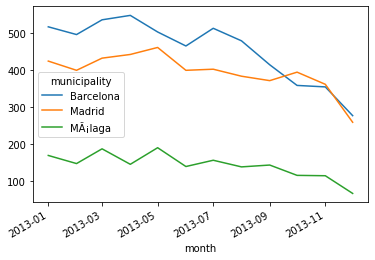

In [41]:
df = res.groupby(['month','municipality']).size()

import matplotlib.pyplot as plt
%matplotlib inline

df.reset_index().pivot(index='month', columns='municipality', values='count').plot()

**Question 4: Matching searches with bookings**

For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. For the bookings file, origin and destination are the columns dep_port and arr_port, respectively. Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.

If you're using Python, can you solve this problem using pandas?

In [42]:
#searches[['event_ts','Seg1Departure', 'Seg1Arrival','Seg1Date']].head()
ks.sql("select event_ts, Seg1Departure, Seg1Arrival, Seg1Date from {searches} limit 5")

,event_ts,Seg1Departure,Seg1Arrival,Seg1Date
0,2013-10-05 03:33:49,CGB,NVT,2014-07-06
1,2013-12-24 02:51:45,STM,CGR,2014-02-12
2,2013-12-23 13:07:27,GRZ,DUS,2014-02-11
3,2013-04-20 11:03:49,GWT,DKR,2013-06-18
4,2013-01-26 06:08:37,BRI,HAM,2013-11-01


In [43]:
#bookings[['act_date','dep_port','arr_port','brd_time']].head()
ks.sql("select act_date, dep_port, arr_port, brd_time from {bookings} limit 5")

,act_date,dep_port,arr_port,brd_time
0,2013-05-22,AAL,BKK,2013-09-29 02:10:00
1,2013-01-08,AAN,MNL,2013-03-24 17:50:00
2,2013-01-15,AAR,CPH,2013-01-15 17:10:00
3,2013-10-25,LHR,CPH,2013-11-22 14:45:00
4,2013-01-29,MAD,AAR,2013-02-11 13:15:00


In [0]:
data = searches.reset_index().assign(event_ts=searches.event_ts.dt.date).assign(Seg1Date=searches.Seg1Date.dt.date).merge(
    bookings.assign(act_date=bookings.act_date.dt.date).assign(brd_time=bookings.brd_time.dt.date), 
    left_on=['event_ts','Seg1Departure', 'Seg1Arrival','Seg1Date'], 
    right_on=['act_date','dep_port','arr_port','brd_time'], how='left')
data = data.drop_duplicates(subset='index', keep='last')
data = data.assign(target=data.dep_port.notnull().astype(int))[searches.columns.tolist()+['target']]

In [0]:
#data.to_csv('ml.csv', num_files=1)

In [0]:
#data.head()

In [47]:
data.target.value_counts()

0    358327
1       677
Name: target, dtype: int64